In [4]:
# Authenticate
from google.colab import auth
import pandas as pd
auth.authenticate_user()

project_id = "cogent-tangent-461710-k9"

# Initialize client with project_id
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

print("✅ BigQuery client initialized for project:", project_id)

✅ BigQuery client initialized for project: cogent-tangent-461710-k9


In [14]:
query = """
    SELECT
        fullVisitorId,
        visitId,
        visitNumber,
        visitStartTime,
        channelGrouping,
        trafficSource.source AS traffic_source,
        trafficSource.medium AS traffic_medium,
        totals.pageviews AS pageviews,
        totals.hits AS hits,
        totals.visits AS visits,
        device.browser AS browser,
        device.operatingSystem AS operatingSystem,
        geoNetwork.country AS country
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
    LIMIT 20000
"""

df = client.query(query).to_dataframe()

print("✅ Data Loaded:", df.shape)
df.head()


✅ Data Loaded: (2556, 13)


,fullVisitorId,visitId,visitNumber,visitStartTime,channelGrouping,traffic_source,traffic_medium,pageviews,hits,visits,browser,operatingSystem,country
0,3418334011779872055,1501591568,1,1501591568,Organic Search,(direct),(none),1,1,1,Chrome,Windows,Greece
1,2474397855041322408,1501589647,2,1501589647,Referral,analytics.google.com,referral,1,1,1,Chrome,Windows,India
2,5870462820713110108,1501616621,1,1501616621,Referral,analytics.google.com,referral,1,1,1,Chrome,Windows,United Kingdom
3,9397809171349480379,1501601200,1,1501601200,Referral,analytics.google.com,referral,1,1,1,Firefox,Windows,United States
4,6089902943184578335,1501615525,1,1501615525,Referral,adwords.google.com,referral,1,1,1,Chrome,Windows,United States


In [15]:
# Convert visitStartTime
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

# Fill missing numeric columns
df['pageviews'] = df['pageviews'].fillna(0)
df['hits'] = df['hits'].fillna(0)
df['visits'] = df['visits'].fillna(0)

# Aggregate per user
user_df = df.groupby('fullVisitorId').agg({
    'visitId': 'nunique',
    'pageviews': 'sum',
    'hits': 'sum',
    'visits': 'sum',
    'channelGrouping': lambda x: x.mode()[0],
    'country': lambda x: x.mode()[0],
    'browser': lambda x: x.mode()[0],
    'operatingSystem': lambda x: x.mode()[0]
}).reset_index()

# Rename columns
user_df.rename(columns={
    'visitId': 'num_visits',
    'pageviews': 'total_pageviews',
    'hits': 'total_hits',
    'visits': 'total_visits'
}, inplace=True)

print("✅ Aggregated User Data:", user_df.shape)
user_df.head()


✅ Aggregated User Data: (2293, 9)


,fullVisitorId,num_visits,total_pageviews,total_hits,total_visits,channelGrouping,country,browser,operatingSystem
0,0004915997121163857,1,1,1,1,Organic Search,United States,Safari,iOS
1,0013182148727187801,1,7,7,1,Direct,United Kingdom,Safari,iOS
2,0015547161740087073,1,1,1,1,Organic Search,United States,Safari,iOS
3,0017557475227585700,1,1,1,1,Referral,United States,Chrome,Macintosh
4,0018642067897203467,1,2,2,1,Organic Search,United States,Safari,iOS


In [16]:
# Define top 20% users as High Value
threshold = user_df['total_pageviews'].quantile(0.80)
user_df['high_value_user'] = (user_df['total_pageviews'] >= threshold).astype(int)

print("✅ Target created: % High Value Users =", user_df['high_value_user'].mean())


✅ Target created: % High Value Users = 0.20104666375926733


In [17]:
# One-hot encoding
X = pd.get_dummies(user_df[[
    'num_visits', 'total_hits', 'total_visits',
    'channelGrouping', 'country',
    'browser', 'operatingSystem'
]])

y = user_df['high_value_user']

print("✅ Features:", X.shape)
print("✅ Target:", y.shape)


✅ Features: (2293, 128)
✅ Target: (2293,)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Train:", X_train.shape, "✅ Test:", X_test.shape)


✅ Train: (1605, 128) ✅ Test: (688, 128)


In [19]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

print("✅ Models trained")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Models trained


In [20]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# RandomForest
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

# Reports
print("📊 RandomForest Report:\n", classification_report(y_test, y_pred_rf))
print("📊 XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

print("🔍 RandomForest ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("🔍 XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


📊 RandomForest Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       550
           1       1.00      0.89      0.94       138

    accuracy                           0.98       688
   macro avg       0.99      0.95      0.96       688
weighted avg       0.98      0.98      0.98       688

📊 XGBoost Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       550
           1       0.95      0.91      0.93       138

    accuracy                           0.97       688
   macro avg       0.97      0.95      0.96       688
weighted avg       0.97      0.97      0.97       688

🔍 RandomForest ROC AUC: 0.9989986824769433
🔍 XGBoost ROC AUC: 0.9981554677206852


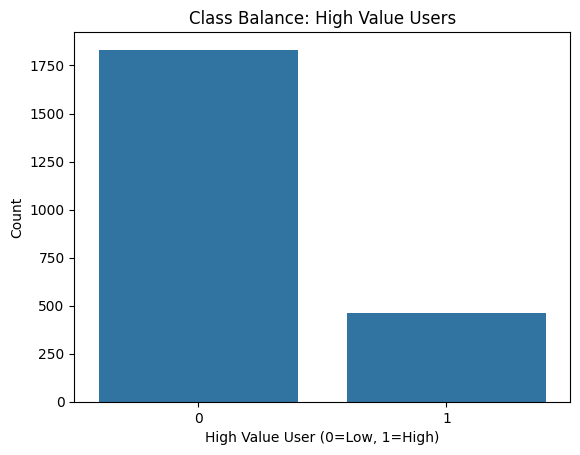

In [26]:
# Class balance plot
sns.countplot(x=user_df['high_value_user'])
plt.title("Class Balance: High Value Users")
plt.xlabel("High Value User (0=Low, 1=High)")
plt.ylabel("Count")
plt.show()


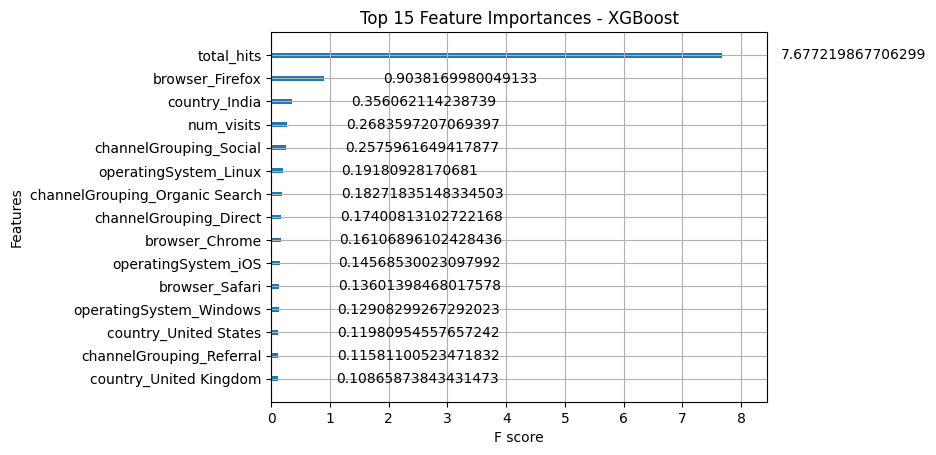

In [25]:
# XGBoost Feature Importance
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()


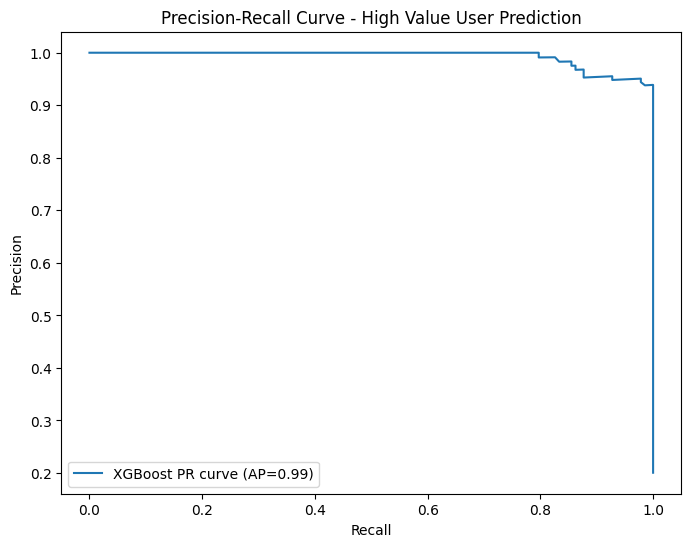

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# PR Curve for XGBoost
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
avg_prec = average_precision_score(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'XGBoost PR curve (AP={avg_prec:.2f})')
plt.title("Precision-Recall Curve - High Value User Prediction")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

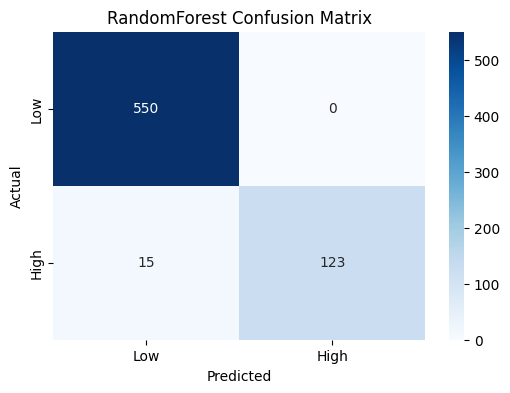

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# RandomForest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


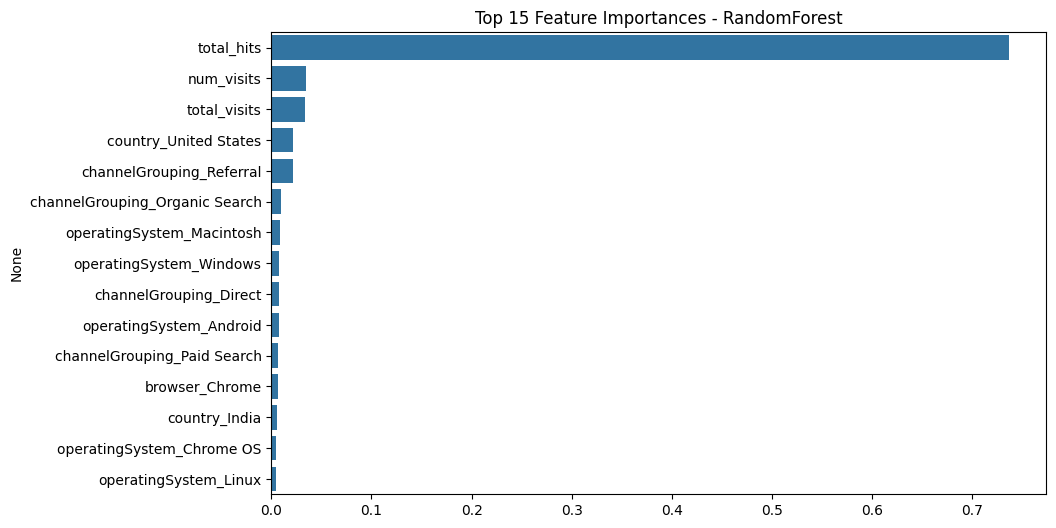

In [22]:
# Feature importance RF
feat_imp_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp_rf.values[:15], y=feat_imp_rf.index[:15])
plt.title("Top 15 Feature Importances - RandomForest")
plt.show()


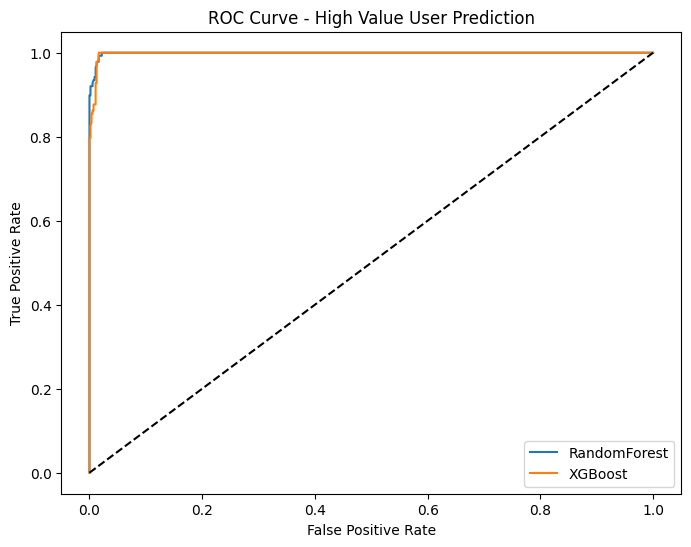

In [23]:
from sklearn.metrics import roc_curve

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# XGB
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label="RandomForest")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - High Value User Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
